<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/best_ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [ ]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [ ]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature data for FA Cup

# Query Google Big Query
fa_cup_features_all = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_features_all_df = client.query(fa_cup_features_all).to_dataframe()
display(fa_cup_features_all_df)




,season_year,match_id,match_name,match_final_score,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,09/10,505337,Chelsea vs Watford,5-0,41837,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,14/15,1138603,Chelsea vs Watford,3-0,41837,1,1,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,16/17,1345813,Chelsea vs Peterborough United,4-1,41837,1,1,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,20/21,201912,Manchester United vs Watford,1-0,74879,1,1,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,09/10,505338,Manchester United vs Leeds United,0-1,74879,1,0,2,3,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,14/15,1142554,Blyth Spartans vs Birmingham City,2-3,<NA>,6,0,64,58,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
346,17/18,949974,Yeovil Town vs Bradford City,2-0,9527,4,1,64,58,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
347,18/19,50205,Woking vs Watford,0-2,6064,6,0,64,58,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0
348,20/21,200806,Chorley FC vs Derby County,2-0,4100,6,1,64,58,64,...,32.75,0.001,0.0,2.36,6.45,1026.75,6.20,69.50,"Snow, Rain, Partially cloudy Partially cloudy",1


In [ ]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [ ]:
def best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt):

    # Define the ranking systems
    ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

    # Split data into training and validation sets
    fa_cup_features_train = fa_cup_features_all_df[~fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]
    fa_cup_features_val = fa_cup_features_all_df[fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]

    # Drop 'season_year, match id, match name' column from both sets so not included in model training but then retain for vlaidation set for futher analysis and comparision
    analysis_columns = ['season_year', 'match_id', 'match_name','match_final_score','home_team_league_level','away_team_league_level']

    fa_cup_features_train = fa_cup_features_train.drop(analysis_columns, axis=1)

    val_analysis_columns = fa_cup_features_val[analysis_columns].copy()
    fa_cup_features_val = fa_cup_features_val.drop(analysis_columns, axis=1)

    # Get all columns except the target and ranking columns
    target_variable = 'target_variable'
    base_features = [col for col in fa_cup_features_train.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

    # Identify numeric and categorical columns
    numeric_features = fa_cup_features_train[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = fa_cup_features_train[base_features].select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ranking_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    if best_model_ranking_used == 'no_ranking':
        features = base_features
    else:
        features = base_features + [f'home_team_{best_model_ranking_used}', f'away_team_{best_model_ranking_used}']

    # Create X_train and y_train
    X_train = fa_cup_features_train[features]
    y_train = fa_cup_features_train[target_variable]

    # Create X_val and y_val
    X_val = fa_cup_features_val[features]
    y_val = fa_cup_features_val[target_variable]

    if home_advt == 'yes':
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)
        numeric_features = [home_advantage_column] + numeric_features

    # Drop home win feature so not used in modelling as
    X_train = X_train.drop('home_win', axis=1)
    X_val = X_val.drop('home_win', axis=1)
    numeric_features = [feat for feat in numeric_features if feat != 'home_win']

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    if best_model_ranking_used != 'no_ranking':
        preprocessor.transformers.append(('rank', ranking_transformer, [f'home_team_{best_model_ranking_used}', f'away_team_{best_model_ranking_used}']))

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_classifier)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val).astype(int)
    #y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    #cr = classification_report(y_val, y_pred, output_dict=True)

    model_name_ranking = f"{model_name} {best_model_ranking_used}"

    results_df, cm_fig, roc_fig = create_model_results_df(y_val, y_pred, accuracy, recall, None, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]
    results_df = results_df[~results_df['metric'].str.startswith('Cross')]

    # Create a DataFrame with features, actual target, and predicted target
    comparison_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': y_pred
    })

    validation_df = X_val.copy()

    for col in analysis_columns:
      if col in val_analysis_columns.columns:
         validation_df[col] = val_analysis_columns[col]

    #display(X_val)

    comparison_df_reset = comparison_df.reset_index(drop=True)
    validation_data_reset = validation_df.reset_index(drop=True)

    all_data_act_pred_df = comparison_df_reset.merge(validation_data_reset, left_index=True, right_index=True)

    return results_df, all_data_act_pred_df



,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,away_team_league_form,...,match_weather_data_hours_humidity,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition
0,41837,1,1,NaN,0.72,0.50,0,2,NaN,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,41837,1,1,0.82,0.00,0.56,0,2,0.81,0.50,...,90.925,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast
2,41837,1,1,0.88,0.00,0.67,0,3,0.77,0.56,...,90.485,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy
3,74879,1,1,0.82,0.00,0.72,0,2,0.63,0.00,...,83.615,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy
4,74879,1,0,NaN,0.67,0.50,0,3,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,<NA>,6,0,NaN,NaN,NaN,0,1,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
345,<NA>,6,0,NaN,NaN,NaN,0,2,0.74,0.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
346,9527,4,1,0.90,0.22,0.39,0,3,0.67,0.67,...,86.840,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy
347,6064,6,0,0.15,NaN,NaN,0,1,0.74,0.33,...,76.860,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast


,metric_id,metric,MLP Classifier Neural Network no_ranking
4,5,Overall Accuracy,0.889
5,6,Confusion Matrix - True Negative (Class 0),28.000
6,7,Confusion Matrix - False Positive (Class 1),1.000
7,8,Confusion Matrix - False Negative (Class 0),4.000
8,9,Confusion Matrix - True Positive (Class 1),12.000
9,10,Precision (Class 0.0),0.875
10,11,Recall (Class 0.0),0.966
11,12,F1-score (Class 0.0),0.918
12,13,Precision (Class 1.0),0.923
13,14,Recall (Class 1.0),0.750


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,0.000,19.35,1000.35,6.80,38.15,Partially cloudy Clear,21/22,1620324,Liverpool vs Shrewsbury Town,4-1
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,0.000,10.35,992.40,12.65,62.20,"Rain, Partially cloudy",21/22,1621206,Chelsea vs Chesterfield,5-1
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,0.000,18.40,998.05,7.05,100.00,Overcast,22/23,6905,Tottenham Hotspur vs Portsmouth,1-0
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,0.000,7.60,1003.55,16.60,32.30,Partially cloudy,21/22,1620344,Tottenham Hotspur vs Morecambe,3-1
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,0.000,8.55,1001.95,18.00,45.70,Partially cloudy,21/22,1620367,Wolverhampton vs Sheffield United,3-0
5,1,0,42682,1,0,0.82,0.39,0.56,1,4,...,0.000,7.30,986.55,15.80,46.05,"Rain, Partially cloudy",22/23,699071,Aston Villa vs Stevenage,1-2
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,0.790,9.40,1002.50,41.45,0.00,Clear,22/23,585832,Leeds United vs Cardiff City,5-2
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,0.000,18.00,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",22/23,6699,Bournemouth vs Burnley,2-4
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,0.000,12.35,987.10,6.75,27.00,Partially cloudy,21/22,1621161,Newcastle United vs Cambridge United,0-1
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,0.315,10.35,991.30,9.50,94.60,"Rain, Overcast",21/22,1620939,Burnley vs Huddersfield Town,1-2


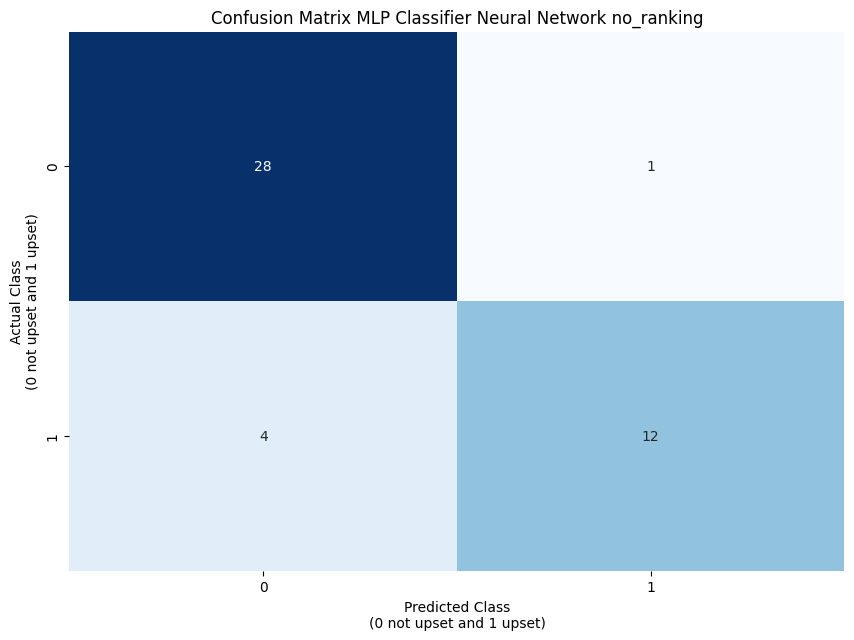

In [ ]:
# MCP Neural Network no home advantage, no ranking
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
best_model_ranking_used =  'no_ranking'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = MLPClassifier( hidden_layer_sizes=(10,),
                                          activation='tanh',
                                          learning_rate_init = 0.1 ,
                                          max_iter=10000,
                                          random_state=47
                                      )
results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_nnn_df = results_df
all_data_act_pred_nnn_df  = all_data_act_pred_df

display(results_nnn_df)
display(all_data_act_pred_nnn_df)





,metric_id,metric,MLP Classifier Neural Network with home advantage massey
4,5,Overall Accuracy,0.844
5,6,Confusion Matrix - True Negative (Class 0),26.000
6,7,Confusion Matrix - False Positive (Class 1),3.000
7,8,Confusion Matrix - False Negative (Class 0),4.000
8,9,Confusion Matrix - True Positive (Class 1),12.000
9,10,Precision (Class 0.0),0.867
10,11,Recall (Class 0.0),0.897
11,12,F1-score (Class 0.0),0.881
12,13,Precision (Class 1.0),0.800
13,14,Recall (Class 1.0),0.750


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_massey,away_team_massey,home_win_factor,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,6.80,38.15,Partially cloudy Clear,3,44,0.75,NaN,<NA>,NaN,NaN
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,12.65,62.20,"Rain, Partially cloudy",2,52,1.0,NaN,<NA>,NaN,NaN
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,7.05,100.00,Overcast,6,26,0.75,NaN,<NA>,NaN,NaN
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,16.60,32.30,Partially cloudy,11,51,0.75,NaN,<NA>,NaN,NaN
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,18.00,45.70,Partially cloudy,21,50,0.5,NaN,<NA>,NaN,NaN
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,15.80,46.05,"Rain, Partially cloudy",30,39,0.0,NaN,<NA>,NaN,NaN
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,41.45,0.00,Clear,16,29,0.5,NaN,<NA>,NaN,NaN
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",25,38,0.5,NaN,<NA>,NaN,NaN
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,6.75,27.00,Partially cloudy,19,46,0.75,NaN,<NA>,NaN,NaN
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,9.50,94.60,"Rain, Overcast",37,13,0.5,NaN,<NA>,NaN,NaN


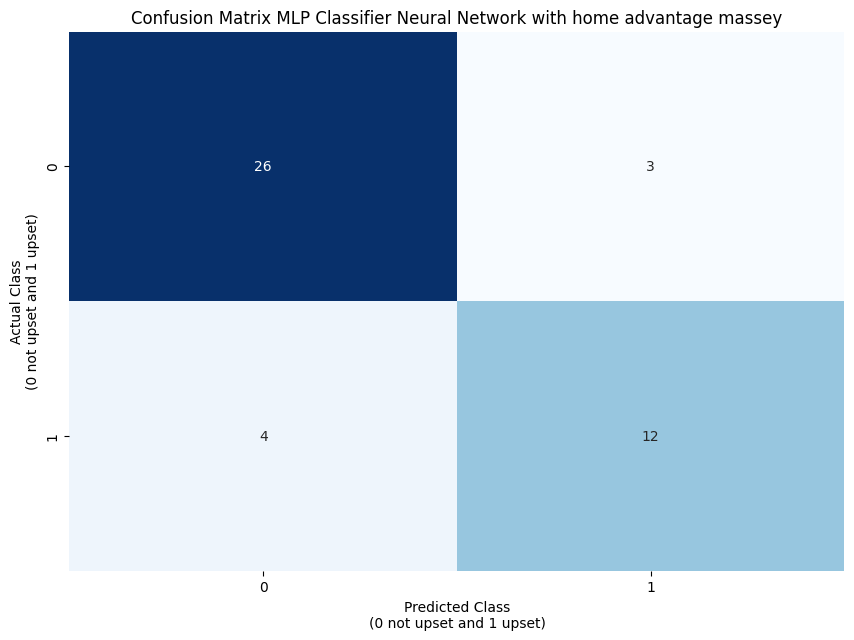

In [ ]:
# MCP Neural Network with home advantage, massey
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
best_model_ranking_used =  'massey'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = MLPClassifier( hidden_layer_sizes=(20,20),
                                          activation='logistic',
                                          learning_rate_init = 0.1 ,
                                          max_iter=10000,
                                          random_state=47
                                      )
results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_nnhm_df = results_df
all_data_act_pred_nnhm_df  = all_data_act_pred_df

display(results_nnhm_df)
display(all_data_act_pred_nnhm_df)





,metric_id,metric,MLP Classifier Neural Network with home advantage keener
4,5,Overall Accuracy,0.911
5,6,Confusion Matrix - True Negative (Class 0),29.000
6,7,Confusion Matrix - False Positive (Class 1),0.000
7,8,Confusion Matrix - False Negative (Class 0),4.000
8,9,Confusion Matrix - True Positive (Class 1),12.000
9,10,Precision (Class 0.0),0.879
10,11,Recall (Class 0.0),1.000
11,12,F1-score (Class 0.0),0.935
12,13,Precision (Class 1.0),1.000
13,14,Recall (Class 1.0),0.750


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_keener,away_team_keener,home_win_factor,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,6.80,38.15,Partially cloudy Clear,4,38,0.75,NaN,<NA>,NaN,NaN
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,12.65,62.20,"Rain, Partially cloudy",5,59,1.0,NaN,<NA>,NaN,NaN
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,7.05,100.00,Overcast,1,35,0.75,NaN,<NA>,NaN,NaN
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,16.60,32.30,Partially cloudy,9,46,0.75,NaN,<NA>,NaN,NaN
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,18.00,45.70,Partially cloudy,7,51,0.5,NaN,<NA>,NaN,NaN
5,1,0,42682,1,0,0.82,0.39,0.56,1,4,...,15.80,46.05,"Rain, Partially cloudy",17,48,0.0,NaN,<NA>,NaN,NaN
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,41.45,0.00,Clear,19,37,0.5,NaN,<NA>,NaN,NaN
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",22,44,0.5,NaN,<NA>,NaN,NaN
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,6.75,27.00,Partially cloudy,11,52,0.75,NaN,<NA>,NaN,NaN
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,9.50,94.60,"Rain, Overcast",26,15,0.5,NaN,<NA>,NaN,NaN


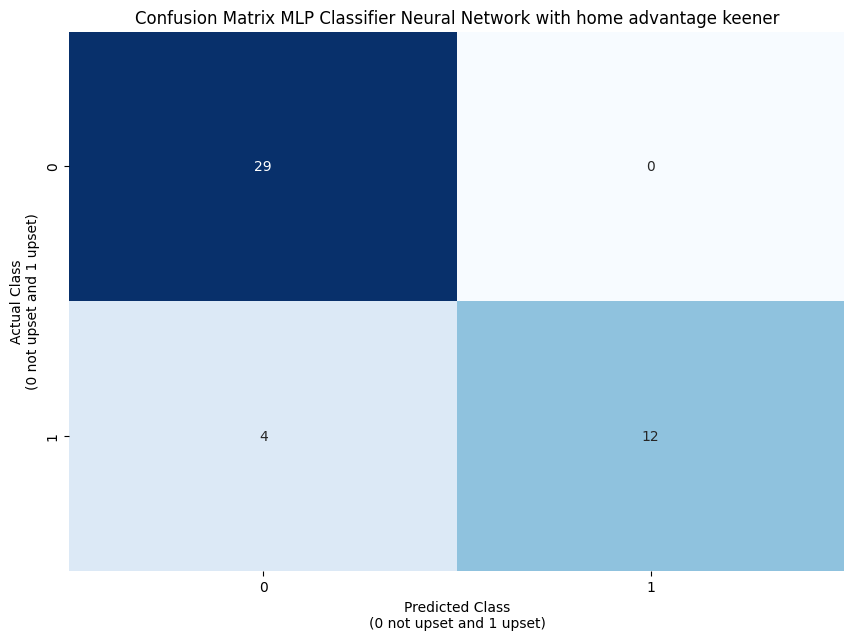

In [ ]:
# MCP Neural Network with home advantage, keener
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
best_model_ranking_used =  'keener'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = MLPClassifier( hidden_layer_sizes=(20,20),
                                          activation='relu',
                                          learning_rate_init = 0.01 ,
                                          max_iter=10000,
                                          random_state=47
                                      )
results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_nnhk_df = results_df
all_data_act_pred_nnhk_df  = all_data_act_pred_df

display(results_nnhk_df)
display(all_data_act_pred_nnhk_df)


,metric_id,metric,MLP Classifier Neural Network with home advantage local_kemeny_optimisation
4,5,Overall Accuracy,0.822
5,6,Confusion Matrix - True Negative (Class 0),26.000
6,7,Confusion Matrix - False Positive (Class 1),3.000
7,8,Confusion Matrix - False Negative (Class 0),5.000
8,9,Confusion Matrix - True Positive (Class 1),11.000
9,10,Precision (Class 0.0),0.839
10,11,Recall (Class 0.0),0.897
11,12,F1-score (Class 0.0),0.867
12,13,Precision (Class 1.0),0.786
13,14,Recall (Class 1.0),0.688


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation,home_win_factor,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,6.80,38.15,Partially cloudy Clear,5,42,0.75,NaN,<NA>,NaN,NaN
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,12.65,62.20,"Rain, Partially cloudy",2,61,1.0,NaN,<NA>,NaN,NaN
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,7.05,100.00,Overcast,4,27,0.75,NaN,<NA>,NaN,NaN
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,16.60,32.30,Partially cloudy,9,53,0.75,NaN,<NA>,NaN,NaN
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,18.00,45.70,Partially cloudy,10,48,0.5,NaN,<NA>,NaN,NaN
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,15.80,46.05,"Rain, Partially cloudy",19,46,0.0,NaN,<NA>,NaN,NaN
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,41.45,0.00,Clear,18,37,0.5,NaN,<NA>,NaN,NaN
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",20,44,0.5,NaN,<NA>,NaN,NaN
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,6.75,27.00,Partially cloudy,17,51,0.75,NaN,<NA>,NaN,NaN
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,9.50,94.60,"Rain, Overcast",31,13,0.5,NaN,<NA>,NaN,NaN


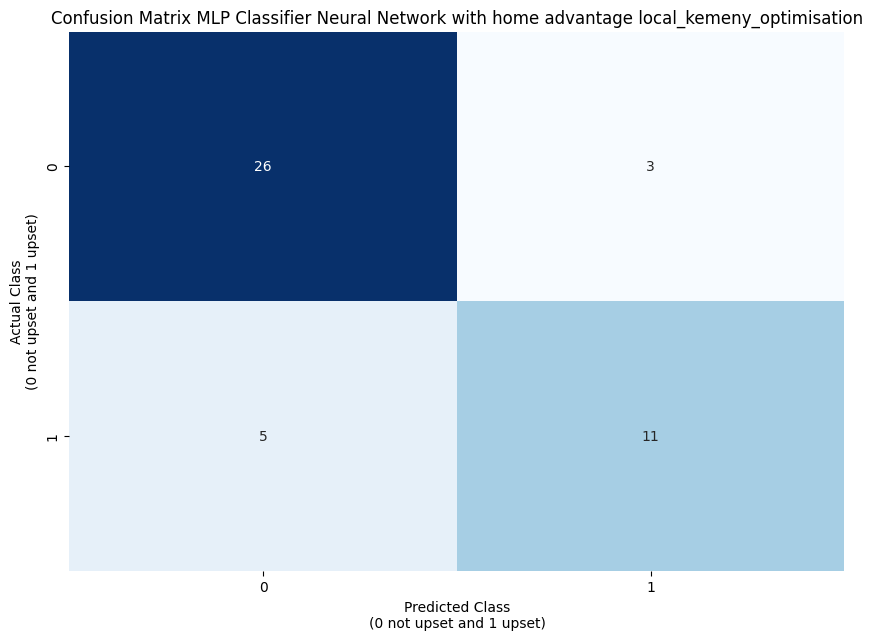

In [ ]:
# MCP Neural Network with home advantage, local kemeny optimisation
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
best_model_ranking_used =  'local_kemeny_optimisation'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = MLPClassifier( hidden_layer_sizes=(20,20),
                                          activation='logistic',
                                          learning_rate_init = 0.1 ,
                                          max_iter=10000,
                                          random_state=47
                                      )
results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_nnhl_df = results_df
all_data_act_pred_nnhl_df  = all_data_act_pred_df

display(results_nnhl_df)
display(all_data_act_pred_nnhl_df)

,metric_id,metric,Random Forest Classifier round_3_position
4,5,Overall Accuracy,1.000
5,6,Confusion Matrix - True Negative (Class 0),29.000
6,7,Confusion Matrix - False Positive (Class 1),0.000
7,8,Confusion Matrix - False Negative (Class 0),0.000
8,9,Confusion Matrix - True Positive (Class 1),16.000
9,10,Precision (Class 0.0),1.000
10,11,Recall (Class 0.0),1.000
11,12,F1-score (Class 0.0),1.000
12,13,Precision (Class 1.0),1.000
13,14,Recall (Class 1.0),1.000


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_round_3_position,away_team_round_3_position,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,1000.35,6.80,38.15,Partially cloudy Clear,2,50,21/22,1620324,Liverpool vs Shrewsbury Town,4-1
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,992.40,12.65,62.20,"Rain, Partially cloudy",3,61,21/22,1621206,Chelsea vs Chesterfield,5-1
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,998.05,7.05,100.00,Overcast,5,49,22/23,6905,Tottenham Hotspur vs Portsmouth,1-0
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,1003.55,16.60,32.30,Partially cloudy,6,52,21/22,1620344,Tottenham Hotspur vs Morecambe,3-1
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,1001.95,18.00,45.70,Partially cloudy,8,29,21/22,1620367,Wolverhampton vs Sheffield United,3-0
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,986.55,15.80,46.05,"Rain, Partially cloudy",11,56,22/23,699071,Aston Villa vs Stevenage,1-2
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,1002.50,41.45,0.00,Clear,14,40,22/23,585832,Leeds United vs Cardiff City,5-2
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",16,21,22/23,6699,Bournemouth vs Burnley,2-4
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,987.10,6.75,27.00,Partially cloudy,18,48,21/22,1621161,Newcastle United vs Cambridge United,0-1
9,1,1,21944,1,0,0.81,0.22,0.17,0,2,...,991.30,9.50,94.60,"Rain, Overcast",19,28,21/22,1620939,Burnley vs Huddersfield Town,1-2


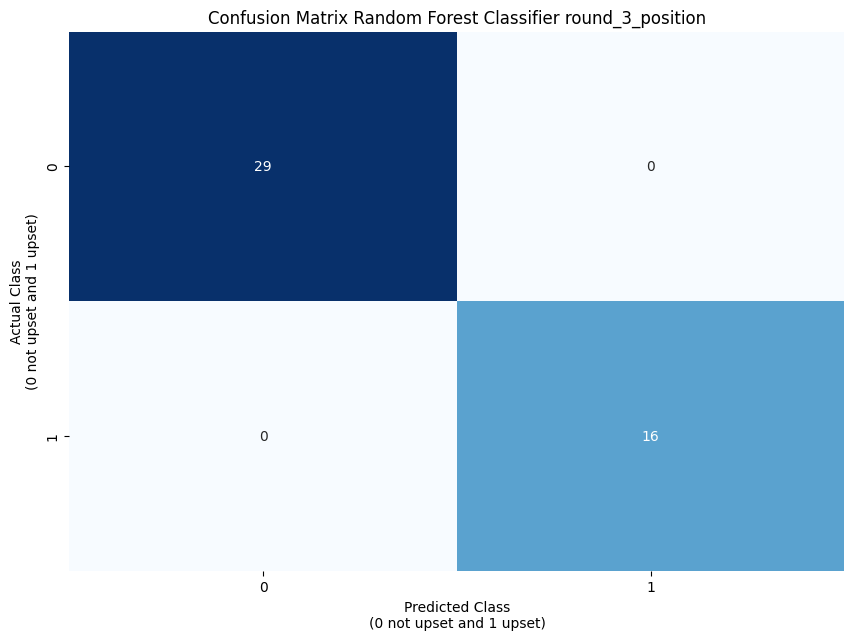

In [ ]:
# Random Forest no home advantage, round_3_position
model_name = "Random Forest Classifier"
home_advt = 'no'
best_model_ranking_used =  'round_3_position'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = RandomForestClassifier(n_estimators = 100 ,
                                          min_samples_leaf = 4 ,
                                          max_features = None,
                                          random_state=47
                                      )

results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_rfr_df = results_df
all_data_act_pred_rfr_df  = all_data_act_pred_df

display(results_rfr_df)
display(all_data_act_pred_rfr_df)

,metric_id,metric,Random Forest Classifier borda_count
4,5,Overall Accuracy,0.978
5,6,Confusion Matrix - True Negative (Class 0),29.000
6,7,Confusion Matrix - False Positive (Class 1),0.000
7,8,Confusion Matrix - False Negative (Class 0),1.000
8,9,Confusion Matrix - True Positive (Class 1),15.000
9,10,Precision (Class 0.0),0.967
10,11,Recall (Class 0.0),1.000
11,12,F1-score (Class 0.0),0.983
12,13,Precision (Class 1.0),1.000
13,14,Recall (Class 1.0),0.938


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_borda_count,away_team_borda_count,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,1000.35,6.80,38.15,Partially cloudy Clear,5,42,21/22,1620324,Liverpool vs Shrewsbury Town,4-1
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,992.40,12.65,62.20,"Rain, Partially cloudy",3,61,21/22,1621206,Chelsea vs Chesterfield,5-1
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,998.05,7.05,100.00,Overcast,4,28,22/23,6905,Tottenham Hotspur vs Portsmouth,1-0
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,1003.55,16.60,32.30,Partially cloudy,9,53,21/22,1620344,Tottenham Hotspur vs Morecambe,3-1
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,1001.95,18.00,45.70,Partially cloudy,10,48,21/22,1620367,Wolverhampton vs Sheffield United,3-0
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,986.55,15.80,46.05,"Rain, Partially cloudy",19,46,22/23,699071,Aston Villa vs Stevenage,1-2
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,1002.50,41.45,0.00,Clear,17,37,22/23,585832,Leeds United vs Cardiff City,5-2
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",20,44,22/23,6699,Bournemouth vs Burnley,2-4
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,987.10,6.75,27.00,Partially cloudy,18,52,21/22,1621161,Newcastle United vs Cambridge United,0-1
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,991.30,9.50,94.60,"Rain, Overcast",31,13,21/22,1620939,Burnley vs Huddersfield Town,1-2


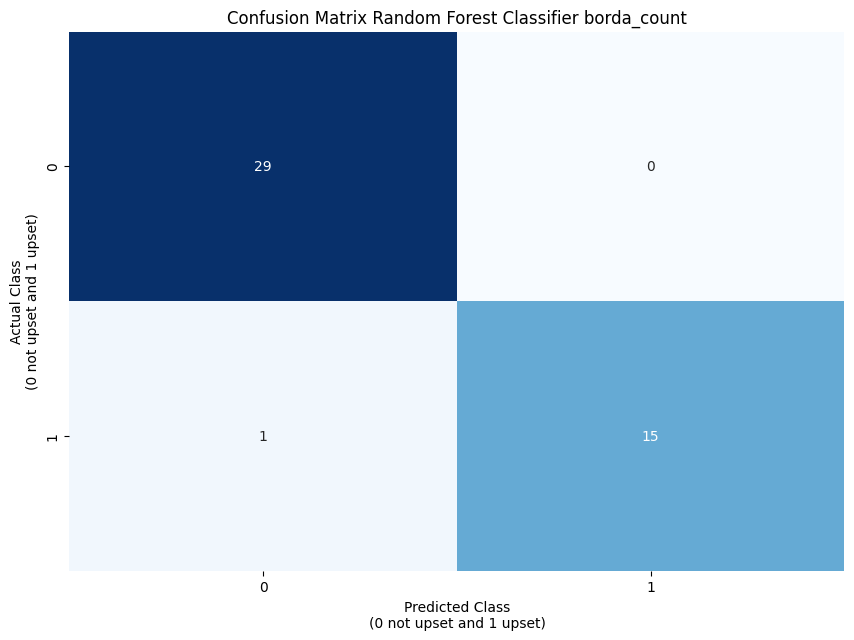

In [ ]:
# Random Forest no home advantage, borda_count
model_name = "Random Forest Classifier"
home_advt = 'no'
best_model_ranking_used =  'borda_count'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = RandomForestClassifier(n_estimators = 100 ,
                                          min_samples_leaf = 1,
                                          max_features = None,
                                          random_state=47
                                      )

results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_rfb_df = results_df
all_data_act_pred_rfb_df  = all_data_act_pred_df

display(results_rfb_df)
display(all_data_act_pred_rfb_df)

,metric_id,metric,Random Forest Classifier local_kemeny_optimisation
4,5,Overall Accuracy,0.978
5,6,Confusion Matrix - True Negative (Class 0),29.000
6,7,Confusion Matrix - False Positive (Class 1),0.000
7,8,Confusion Matrix - False Negative (Class 0),1.000
8,9,Confusion Matrix - True Positive (Class 1),15.000
9,10,Precision (Class 0.0),0.967
10,11,Recall (Class 0.0),1.000
11,12,F1-score (Class 0.0),0.983
12,13,Precision (Class 1.0),1.000
13,14,Recall (Class 1.0),0.938


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,1000.35,6.80,38.15,Partially cloudy Clear,5,42,21/22,1620324,Liverpool vs Shrewsbury Town,4-1
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,992.40,12.65,62.20,"Rain, Partially cloudy",2,61,21/22,1621206,Chelsea vs Chesterfield,5-1
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,998.05,7.05,100.00,Overcast,4,27,22/23,6905,Tottenham Hotspur vs Portsmouth,1-0
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,1003.55,16.60,32.30,Partially cloudy,9,53,21/22,1620344,Tottenham Hotspur vs Morecambe,3-1
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,1001.95,18.00,45.70,Partially cloudy,10,48,21/22,1620367,Wolverhampton vs Sheffield United,3-0
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,986.55,15.80,46.05,"Rain, Partially cloudy",19,46,22/23,699071,Aston Villa vs Stevenage,1-2
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,1002.50,41.45,0.00,Clear,18,37,22/23,585832,Leeds United vs Cardiff City,5-2
7,1,1,11700,1,0,0.82,0.00,0.17,0,2,...,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",20,44,22/23,6699,Bournemouth vs Burnley,2-4
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,987.10,6.75,27.00,Partially cloudy,17,51,21/22,1621161,Newcastle United vs Cambridge United,0-1
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,991.30,9.50,94.60,"Rain, Overcast",31,13,21/22,1620939,Burnley vs Huddersfield Town,1-2


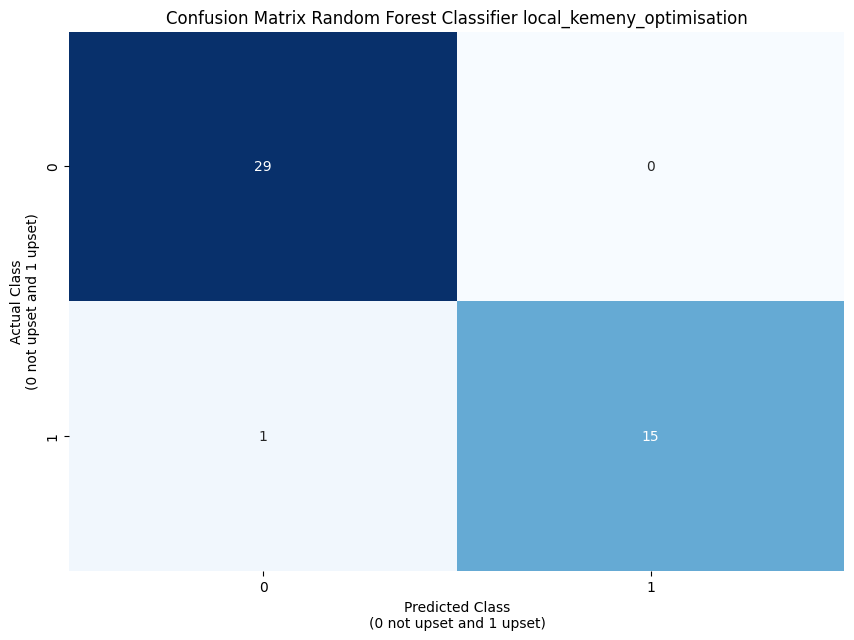

In [ ]:
# Random Forest no home advantage, local_kemeny_optimisation
model_name = "Random Forest Classifier"
home_advt = 'no'
best_model_ranking_used =  'local_kemeny_optimisation'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = RandomForestClassifier(n_estimators = 100 ,
                                          min_samples_leaf = 1 ,
                                          max_features = None,
                                          random_state=47
                                      )

results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_rfl_df = results_df
all_data_act_pred_rfl_df  = all_data_act_pred_df

display(results_rfl_df)
display(all_data_act_pred_rfl_df)

,metric_id,metric,XG Boost round_3_position
4,5,Overall Accuracy,0.889
5,6,Confusion Matrix - True Negative (Class 0),29.000
6,7,Confusion Matrix - False Positive (Class 1),0.000
7,8,Confusion Matrix - False Negative (Class 0),5.000
8,9,Confusion Matrix - True Positive (Class 1),11.000
9,10,Precision (Class 0.0),0.853
10,11,Recall (Class 0.0),1.000
11,12,F1-score (Class 0.0),0.921
12,13,Precision (Class 1.0),1.000
13,14,Recall (Class 1.0),0.688


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_team_round_3_position,away_team_round_3_position,season_year,match_id,match_name,match_final_score
0,0,0,53394,1,1,0.69,0.83,0.44,0,3,...,1000.35,6.80,38.15,Partially cloudy Clear,2,50,21/22,1620324,Liverpool vs Shrewsbury Town,4-1
1,0,0,41837,1,1,0.67,0.39,0.39,0,5,...,992.40,12.65,62.20,"Rain, Partially cloudy",3,61,21/22,1621206,Chelsea vs Chesterfield,5-1
2,0,0,62850,1,1,NaN,0.00,0.39,0,3,...,998.05,7.05,100.00,Overcast,5,49,22/23,6905,Tottenham Hotspur vs Portsmouth,1-0
3,0,0,62850,1,1,0.88,0.56,0.39,0,3,...,1003.55,16.60,32.30,Partially cloudy,6,52,21/22,1620344,Tottenham Hotspur vs Morecambe,3-1
4,0,0,32050,1,1,0.88,0.00,0.72,1,2,...,1001.95,18.00,45.70,Partially cloudy,8,29,21/22,1620367,Wolverhampton vs Sheffield United,3-0
5,1,1,42682,1,0,0.82,0.39,0.56,1,4,...,986.55,15.80,46.05,"Rain, Partially cloudy",11,56,22/23,699071,Aston Villa vs Stevenage,1-2
6,0,0,39460,1,1,0.82,0.00,0.11,0,2,...,1002.50,41.45,0.00,Clear,14,40,22/23,585832,Leeds United vs Cardiff City,5-2
7,1,0,11700,1,0,0.82,0.00,0.17,0,2,...,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",16,21,22/23,6699,Bournemouth vs Burnley,2-4
8,1,1,52409,1,0,0.72,0.00,0.28,0,3,...,987.10,6.75,27.00,Partially cloudy,18,48,21/22,1621161,Newcastle United vs Cambridge United,0-1
9,1,0,21944,1,0,0.81,0.22,0.17,0,2,...,991.30,9.50,94.60,"Rain, Overcast",19,28,21/22,1620939,Burnley vs Huddersfield Town,1-2


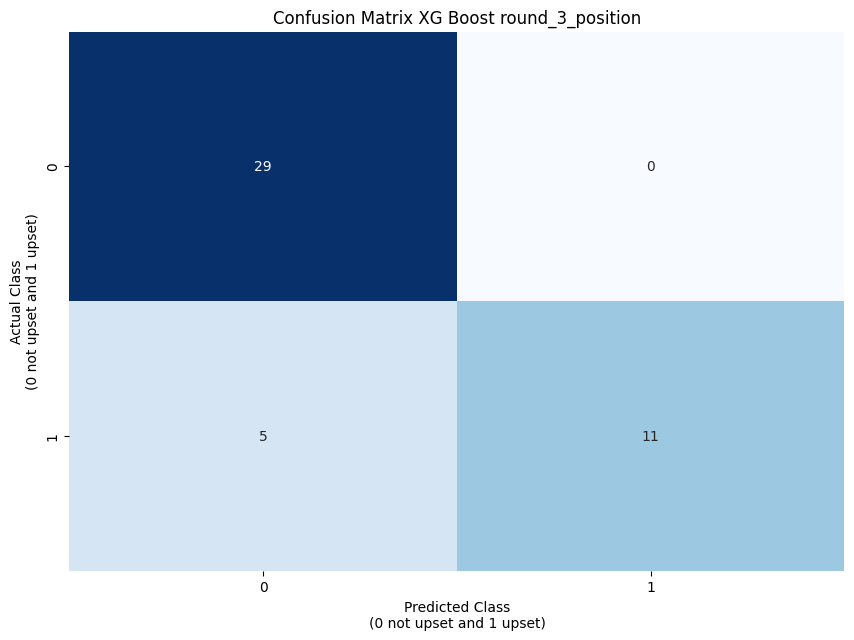

In [ ]:
# XG Boost no home advantage, round_3_position
model_name = "XG Boost"
home_advt = 'no'
best_model_ranking_used =  'round_3_position'

#Best Parameters from cross-validation folds evaluation analysis
model_classifier  = XGBClassifier(
                         max_depth=5,
                         min_child_weight=2,
                         subsample=1,
                         colsample_bytree=1.0,
                         learning_rate=0.01,
                         random_state=47
                        )

results_df, all_data_act_pred_df = best_model_classifier (fa_cup_features_all_df, model_classifier, model_name, best_model_ranking_used, home_advt)

results_xgr_df = results_df
all_data_act_pred_xgr_df  = all_data_act_pred_df

display(results_xgr_df)
display(all_data_act_pred_xgr_df)


